# The Coronavirus Pandemic in Data: Insights from Hospital Capacity and the Stock Market

## Submission for Fundamentals of Social Data Science

### 9 December 2020

## Candidate number: 1378359

### Word Count: 3094

## Part 1 - Setup

## Introduction

The worldwide spread of the SARS-CoV-2 virus (coronavirus) has lead to outbreaks of COVID-19 in many countries that have put a strain on national healthcare systems. In some countries, the demand for healthcare services even exceeded the capacity of hospitals, causing patients suffering from long-term illness not to be able to receive necessary treatments. While some countries seemed to be well-prepared to meet the excess demand due to COVID, others seemed to be struggling. One important factor in this regard is the availability of hospital and ICU beds (Bauer et al., 2020). Bauer et al. (2020) find that "geographical access to intensive care beds varies significantly across European countries", and that "low ICU accessibility was associated with a higher proportion of COVID-19 deaths to cases". This conclusion is supported by Sussman (2020), using a larger and more geographically-spread sample of countries. 

In order to reduce transmission and prevent their medical infrastructure from becoming overwhelmed, many countries adopted strict social-distancing measures such as travel restrictions, school closures, or even complete lockdowns (Davies et al., 2020). Many of these measures are associated with severe social and economic costs (Bonaccorsi et al., 2020). This prompts the question of whether countryies with higher hospital capacity, and therefore a lower risk of seeing its healthcare system overwhelmed by excess capacity, can avoid such social and economic costs by adopting less stringent measures against the spread of COVID. In other words, do governments of countries with higher hospital capacity choose to adopt less stringent measures against COVID-19? 

### Literature Review
Previous literature on the relationship between hospital capacity and government response suggests that in countries with lower hospital capacity, more stringent economic stimulus is adopted Elgin et al. (2020), and that countries with higher hospital capacity were slower to adopt COVID-19 restrictions (Sebhatu et al., 2020). While Sussman (2020) puts forward the theoretical argument that higher mortality as a result of lower hospital capacity could induce governments to take more stringent measures, the empirical relationship between hospital capacity and stringency of measures remains unclear from the literature and therefore warrants further study.

### Methods and data

In order to answer the research question, I will be drawing upon data from the OxCOVID19 database (Mahdi et al., 2020). The dependent variable, government stringency will be drawn from the Blavatnik School of Government's Government Response Tracker which presents a 'stringency index' that combines 9 different factors, such as to what extent a government closed schools or imposed restrictions on gatherings (Hale et al., 2020). I operationalize the main independent variable, hospital capacity, as the number of hospital beds available per 1000 inhabitants, which is measured by the World Health Organization and included in the OxCOVID19 database. Furthermore, in order to be able to gauge the effect of potential confounding variables, I include gross domestic product (GDP) per capita, population, and the number of confirmed COVID cases (based on the WHO official statistics) in my analysis. 

### Transformations
Inspecting the most recent year of measurement for my variables, we can see that the independent variable is very outdated for several countries. Since these outdated values are likely to be unreliable, I remove the observations for 35 countries with values that are more than 10 years outdated. Furthermore, in order to normalize it, I transform the gdp per capita variable by using the logarithm function. Finally, I transform the data from time-series to static data. In order to able to make a fair comparison between countries, I do so by taking the average of the values during the period since each country's tenth infection. 

## Part 1 - Data Analysis in Python

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import json
import requests
from os import makedirs
from os.path import join, exists
from datetime import date, timedelta
from time import sleep
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Installing psycopg2 - PostgreSQL Database Adapter
# Requires an installation of PostgreSQL on your machine
try: 
    import psycopg2
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install psycopg2
    import psycopg2

sns.set_theme(style='whitegrid') # Setting seaborn theme
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True) # Color map for plots

In [50]:
# Establishing connection to the OXCOVID-19 Database. Code snippet taken from: https://github.com/covid19db/examples/blob/master/data-loading/data-access-postgresql.ipynb

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [51]:
# Obtaining data from the database

sql_command = """
SELECT government_response.date, 
government_response.country, 
government_response.countrycode, 
MAX(epidemiology.confirmed) AS confirmed, 
MAX(government_response.stringency_index) AS stringency_index, 
MAX(government_response.economic_support_index) AS economic_support_index,
MAX(CASE WHEN world_bank.indicator_name = 'Hospital beds (per 1,000 people)' THEN world_bank.value END) AS beds,
MAX(CASE WHEN world_bank.indicator_name = 'Population, total' THEN world_bank.value END) AS population,
MAX(CASE WHEN world_bank.indicator_name = 'GDP (current US$)' THEN world_bank.value END) AS gdp,
MAX(CASE WHEN world_bank.indicator_name = 'Hospital beds (per 1,000 people)' THEN world_bank.year END) AS beds_year,
MAX(CASE WHEN world_bank.indicator_name = 'Population, total' THEN world_bank.year END) AS population_year,
MAX(CASE WHEN world_bank.indicator_name = 'GDP (current US$)' THEN world_bank.year END) AS gdp_year
FROM government_response 
INNER JOIN world_bank ON government_response.countrycode = world_bank.countrycode
INNER JOIN epidemiology ON government_response.countrycode = epidemiology.countrycode AND government_response.date = epidemiology.date
WHERE world_bank.indicator_name IN ('Hospital beds (per 1,000 people)', 'Population, total', 'GDP (current US$)') AND epidemiology.source = 'WRD_WHO'
GROUP BY government_response.countrycode, government_response.country, government_response.date
ORDER BY government_response.date DESC
"""

df = pd.read_sql(sql_command, conn)

In [52]:
# Data Cleaning

# There are some outdated values of the World Bank variable, which could influence our results. Removing values which are >10 years old. 
df_cleaned = df.loc[(df['beds_year']>2009) & (df['population_year']>2009) & (df['gdp_year']>2009)]
diff = (len(df['country'].unique()) - len(df_cleaned['country'].unique()))
left_over = len(df_cleaned['country'].unique())
print(f"Removed {diff} countries with outdated values, {left_over} countries left in the dataset.")

# After removing countries with outdated values for the world bank variables, we have 161 countries left. GDP and population data are relatively up-to-date for most countries. 

Removed 35 countries with outdated values, 161 countries left in the dataset.


In [53]:
# Inspecting 'confirmed' variable, since we are interested in measures taken by governments during the pandemic, we will only consider situations where the number of confirmed cases in a country is 10 or more

df_cleaned = df_cleaned.loc[df_cleaned['confirmed']>9] 

In [54]:
# Aggregating the data on country level

df_grouped_mean = df_cleaned.groupby(['country', 'countrycode']).mean()
df_grouped_mean = df_grouped_mean.reset_index(level=['countrycode'])

In [55]:
# Constructing per capita measures of GDP

df_grouped_mean['gdppc'] = df_grouped_mean['gdp']/df_grouped_mean['population']
df_grouped_mean['loggdppc'] = np.log(df_grouped_mean['gdppc'])

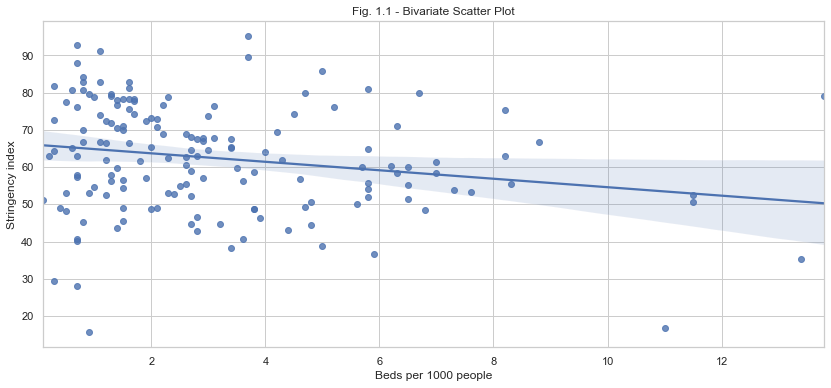

In [56]:
# We begin by looking at a simple scatterplot of the correlation between beds and stringency. It seems that there is a slight negative correlation, but there are also some outliers and we see a lot of variance in stringency especially for countries with a lower number of beds
temp = df_grouped_mean[df_grouped_mean['loggdppc']>=6]

plt.figure(figsize=(14,6))
ax = sns.regplot(x='beds', y='stringency_index', data=temp)
ax.set(xlabel='Beds per 1000 people', ylabel='Stringency index', title='Fig. 1.1 - Bivariate Scatter Plot')
plt.show()

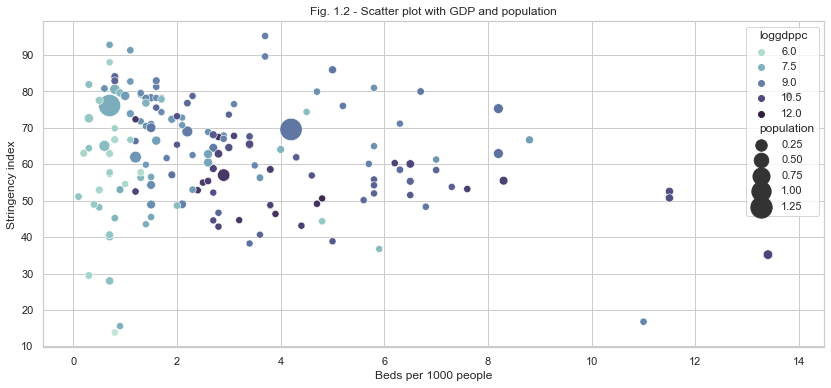

In [57]:
# Let's look at the relationship in more detail by adding two more dimensions to the graph: GDP per capita (as a measure of a country's prosperity) and population size
# It appears that most of the countries with <2 beds per 1000 people are poorer countries, perhaps the high variance in stringency here is caused by confounding variables such as level of democracy that we have not taken into account. 

plt.figure(figsize=(14,6))
ax = sns.scatterplot(x='beds', y='stringency_index', hue='loggdppc', size="population", sizes=(50, 500), palette=cmap, data=df_grouped_mean)
ax.set(xlabel='Beds per 1000 people', ylabel='Stringency index', title='Fig. 1.2 - Scatter plot with GDP and population')
plt.show()

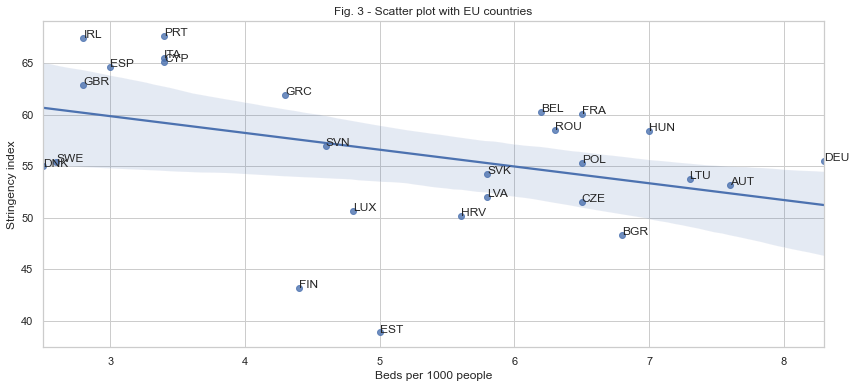

In [58]:
# By looking at European countries only we can keep some factors such as governance relatively constant

# Subsetting the data frame to include only european countries
european_countries = ['AUT', 'BEL', 'BGR', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ITA', 'LTU', 'LUX', 'LVA', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'SWE'] # List with countrycodes of European countries
df_grouped_mean_eu = df_grouped_mean.loc[df_grouped_mean['countrycode'].isin(european_countries)]

# Plotting
plt.figure(figsize=(14,6))
ax = sns.regplot(x='beds', y='stringency_index', data = df_grouped_mean_eu)
ax.set(xlabel='Beds per 1000 people', ylabel='Stringency index', title='Fig. 3 - Scatter plot with EU countries')

for i, txt in enumerate(df_grouped_mean_eu['countrycode']):
    ax.annotate(txt, (df_grouped_mean_eu['beds'][i], df_grouped_mean_eu['stringency_index'][i]))

plt.show()

In [70]:
df_grouped_mean_temp = df_grouped_mean.dropna()

def pearsonr_ci(x,y,alpha=0.05): # Adapted from: https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
    '''
    This function computes a confidence interval around the pearson correlation coeffcient 
    '''
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r.round(2), p.round(2), lo.round(2), hi.round(2)

total = pearsonr_ci(df_grouped_mean_temp['beds'], df_grouped_mean_temp['stringency_index'])
eu = pearsonr_ci(df_grouped_mean_eu['beds'], df_grouped_mean_eu['stringency_index'])

table = pd.DataFrame([],columns=["Correlation coefficient", 'Confidence interval', "p-value"],
                           index=["All countries", "EU countries"])

table.loc["All countries"]= [total[0], (total[2], total[3]), total[1]]
table.loc["EU countries"]= [eu[0], (eu[2], eu[3]), eu[1]]

display(table)
print("Table 1.1 Correlation coefficients and confidence intervals")

,Correlation coefficient,Confidence interval,p-value
All countries,-0.18,"(-0.33, -0.03)",0.02
EU countries,-0.4,"(-0.68, -0.01)",0.04


Table 1.1 Correlation coefficients and confidence intervals


## Part 1 - Discussion of results

Figure 1.1 gives us an initial idea of the bivariate relationship between hospital capacity and government stringency. Overall, there appears to be a moderately strong negative correlation between the two variables, meaning that countries with higher hospital capacity tend to be associated with less stringent COVID measures. 

However, figure 1.1 also shows that there are several outliers. Especially among countries with a low (<2) number of hospital beds per 1000 capita, we observe large variation in stringency. This variation could be explained by the presence of confounding variables, factors that affect both the number of hospital beds and government stringency, that we have not taken into account in our analysis. One such variable might be the level of economic development of a country. Economic development creates wealth that may allow governemnts to invest in their country's healthcare system, while at the same time affecting the strenght of political institutions through which that government can enforce rules (Lange & Vollmer, 2017; Rodrik, 2004). Furthermore, on the other end of figure 1.1, we observe a large amount of variance in measure stringency between countries with a very high (>10) number of hospital beds per capita. This effect could be a result of population size, which may effect the per capita number of hospital beds as well as the speed at which the coronavirus spreads (Stier, Berman & Bettancourt, 2020). 

In figure 1.2, I integrate the effect of two potential confounding variables into the scatterplot, the logarithm of gross domestic product (GDP) per capita as a measure of economic development, and population size. GDP is represented as a color scale while population size is represented by the size of each dot. Figure 1.2 shows that countries with a low number of beds per capita in combination with low measure stringency are indeed mostly lower-income countries. Furthermore, the outliers with a high number of beds per capita do not seem to be related to population size. 

One way we can attempt to control for some of differences between countries that exist due to their level of economic development and their insitutional structures, is to look at a group of countries that are similar in this respect. The European Union is one such group of countries that are relatively similar economically and culturally. In figure 1.3, we see the bivariate relationship between hospital capacity and stringency plotted for European countries. The graph shows that when looking at European countries only, we can still observe a moderate linear correlation with a slightly more strongly negative direction compared to when we look at all countries. However, in this plot we can again identify two influential outliers, namely Sweden and Denmark on the far left end of the x-axis. The Swedish case has been documented in the press arguably as the main example of a diverging strategy to handle the pandemic. Lindström (2020) links the Swedish strategy to the rise in post-materialist values and postmodernism in the country. This indicates that the unexplained variance within our bivariate analyses may be explained by cultural values that we have not taken into account in this analysis.

Drawing together the results that are shown graphically in figures 1.1, 1.2, and 1.3, table 1.1 shows the pearson correlation coefficients of the bivariate relationship between hospital capacity and stringency. From table 1.1, we can tell that the correlation is indeed stronger when looking at European countries only. Furthermore, neither of the confidence intervals include 0 and therefore we can say with 95% confidence that the true correlation between hospital capacity and stringency is negative. 

# How did Different Sources of Information about COVID Affect the Stock Market's Response to the Crisis?

## Part 2 - Setup

### Introduction
The outbreak of the coronavirus has not only lead to a global public health emergency, but has also ravaged ﬁnancial markets. On the 16th of March, the New York Sto ck Exchange on Wall Street suﬀered its worst day since 1987, surpassing other moments such as 9/11 and the 2008 Financial Crisis. On the other hand, by late April, sto ck markets had started to recover and share prices started rising again (Barrero Blo om, 2020). Furthermore, comparing stock market resp onses to past outbreaks of infectious diseases, Barrero and Bloom (2020) ﬁnd that these past episo des ”do not even remotely resemble” the response due to COVID-19.

The fact that this stock market response in early March was so severe begs the question of which factors influenced the severity of this response. In particular, since previous crises such as the 2002-2004 SARS outbreak and the 2008 financial crisis, the global rise of social media and internet connectivity has caused an unprecedented availability of (mis)information about COVID-19 at users' fingertips (Chan, Nickson, Rudolph, Lee, & Joynt, 2020; Strekalova, 2017). Could it be that panic induced by online information about the coronavirus or news coverage on the virus has contributed to the severity of the stockmarket crash? On the other hand, the efficient market hypothesis within financial economics states that prices of financial assets at all times reflect all the available information (Malkiel, 1989). According to this theory, variations in market outcomes should thus only occur if new information becomes available and cannot solely be based on increasing attention to pre-existing information. In this section of the paper, I will investigate the following research question: what is the predictive power of different sources of information about the coronavirus on stock market variation? To address this question, I will look at the time series of three different potential predictors and compare their correlation coefficients with market variation at several different time lags. The period that I will be observing is the initial stage of the pandemic from January until May 2020, when the variation in market outcomes was highest. 

### A Look at the Literature
Within the relatively short timespan since the beginning of the financial recession in March, several articles have explored the response of financial markets to the coronavirus pandemic. Baker et al. (2020) find that the market response cannot be directly attributed simply to epidemiological information about the virus, but rather to non-pharmaceutical interventions by governments, such as social distancing measures. Similarly, Baig et al. (2020) find that implementations of national restrictions lead to increased market volatility, but unlike Baker et al. (2020) they do find that confirmed cases and deaths have a significant effect on market volatility. Haroon et al. (2020) find that panic generated by news outlets is associated with increased stock market volatility. They refer to a seminal work within cognitive psychology by Griffin & Tversky (1992) who argue that "people focus on the strength or extremeness of the available evidence with insufficient regard for its weight or credence". 

Another strand of literature has explored the relationship between data generated on the web and stock market variations. Preis, Reith, and Stanley (2010); Preis, Moat, and Stanley (2013); Lyócsa, Baumöhl, Vyrost, and Molnár (2020) ﬁnd evidence that variations in Google search behavior for speciﬁc stock-related terms is associated with movements in ﬁnancial markets. Looking at Wikipedia edits, Moat et al. (2013) similarly relate increased frequency of edits to certain Wikipedia pages to stock market moves. Finally, Si et al. (2013) ﬁnd that sentiment expressed on Twitter about a range of topics can predict stock market outcomes

### Data and Methods
In this section, I will compare to what extent the outcomes on the stock market in early March could have been predicted by three different sources of infomation. Firstly, I will look at Google search trends for the term 'coronavirus', for this I will use the Python library `pytrends` which works as a wrapper around the Google search trends API. This API returns normalized values of hte popularity of a search term on a scale of 0 to 100. Secondly, I will look at the number of articles containing a mention of the coronavirus that were published by the Guardian over time. This data is available through the Guardian API with a free developer key. Finally, I will examine the effect of changes in the British government's response to the crisis which may have had severe economic implications. This data will again be drawn from the OxCOVID19 database (Mahdi et al., 2020). The dependent variable, stock market reaction will be measured as the daily trading volume of all shares in the Financial Times Stock Exchange 100 index. These index represents the 100 companies with the highest market capitalization on the London Stock Exchange. In this case, high trading volume indicates that many investors are wanting to sell these stocks, which is caused by changing expectations of the underlying value of the stock. Volume data is obtained through the Python library `yfinance`, a wrapper around the Yahoo Finance API. 


## Part 2 - Data Analysis in Python

In [14]:
from pytrends.request import TrendReq
import yfinance as yf

In [ ]:
keys = json.loads(open("keys.json").read())

params = {
    'from-date': "2020-01-01",
    'to-date': "2020-04-30",
    'order-by': "newest",
    'show-fields': 'webTitle',
    'page-size': 200, # Max page size
    'api-key': keys['GUARDIANKEY']
}

def guardian_download(key=keys['GUARDIANKEY'], params=params): # Adapted from https://gist.github.com/dannguyen/c9cb220093ee4c12b840

    '''
    This function retrieves data from the Guardian API
    '''
    
    MY_API_KEY = keys['GUARDIANKEY']
    API_ENDPOINT = 'http://content.guardianapis.com/search?q=coronavirus%20OR%20covid'
    my_params = params

    start_date = date(2020, 1, 1)
    end_date = date(2020, 4, 30)
    dayrange = range((end_date - start_date).days + 1)

    df = pd.DataFrame()

    for day in dayrange:
        dt = start_date + timedelta(days=day)
        datestr = dt.strftime('%Y-%m-%d')

        print("Downloading", datestr)
        all_results = []
        my_params['from-date'] = datestr
        my_params['to-date'] = datestr
        current_page = 1
        total_pages = 1
        while current_page <= total_pages: # Loops until all pages of the results are read
            print("...page", current_page)
            my_params['page'] = current_page
            response = requests.get(API_ENDPOINT, my_params)
            data = response.json()
            temp = pd.json_normalize(data['response']['results'])
            df = df.append(temp, ignore_index=True)

            current_page += 1
            total_pages = data['response']['pages']

        sleep(0.5)  # Reduce load

    return df

guardian_df = guardian_download(key, params)

guardian_df.to_csv('guardian_covid.csv') # Saving data to file so we don't have to keep requesting it

In [60]:
# Loading data from file

guardian_df = pd.read_csv('guardian_covid.csv')
guardian_df.index = pd.to_datetime(guardian_df['webPublicationDate'])
guardian_df.index = guardian_df.index.tz_localize(None)
guardian_df = guardian_df.resample('d').count()
guardian_df = guardian_df['webTitle']

In [61]:
# Google data

pytrends = TrendReq(hl='World', tz=0)
pytrends.build_payload(kw_list=['coronavirus'], timeframe='2020-01-01 2020-04-30')
google_df = pytrends.interest_over_time()

In [62]:
# Yahoo Finance data

FTSE = yf.Ticker("^FTSE")
ftse_df = FTSE.history(start="2020-01-01", end="2020-04-30")['Volume']

In [63]:
# OxCOVID19 data

sql_command = """
SELECT date, government_response_index
FROM government_response 
WHERE date BETWEEN '2020/01/01' AND '2020/04/30' and countrycode = 'GBR'
ORDER BY date DESC
"""

covid_df = pd.read_sql(sql_command, conn)
covid_df.index = pd.to_datetime(covid_df['date'])

In [64]:
# Merging everything together

df_total = covid_df.merge(guardian_df, left_index=True, right_index=True).merge(google_df, left_index=True, right_index=True).merge(ftse_df, left_index=True, right_index=True)

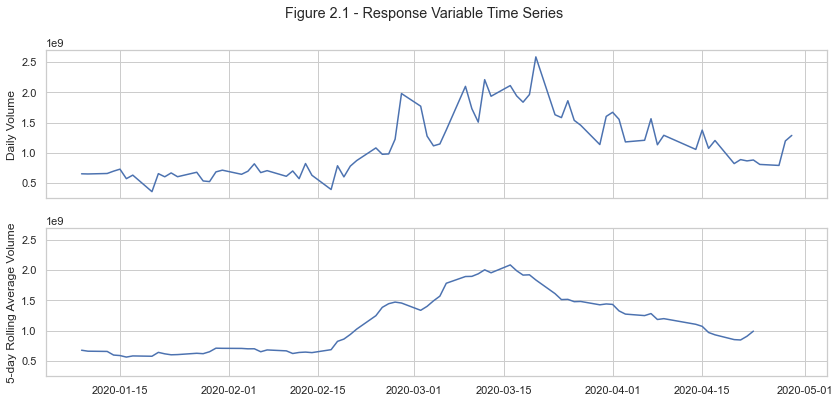

In [65]:
# Plotting Volume

f, axes = plt.subplots(2,1, figsize=(14, 6), sharex=True, sharey=True)

sns.lineplot(data=df_total.Volume, ax = axes[0])
axes[0].set(ylabel='Daily Volume')
sns.lineplot(data=df_total.rolling(5).mean().Volume, ax = axes[1])
axes[1].set(ylabel='5-day Rolling Average Volume')
f.suptitle('Figure 2.1 - Response Variable Time Series')
plt.show()

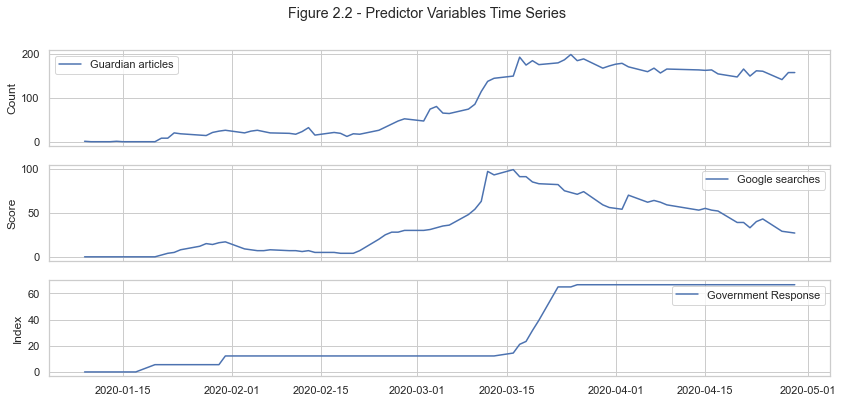

In [66]:
# Plotting predictor time series

f, axes = plt.subplots(3,1, figsize=(14, 6), sharex=True, sharey=False)

sns.lineplot(data=df_total.webTitle, label ='Guardian articles', ax=axes[0])
axes[0].set(ylabel='Count')
sns.lineplot(data=df_total.coronavirus, label ='Google searches', ax=axes[1])
axes[1].set(ylabel='Score')
sns.lineplot(data=df_total.government_response_index, label ='Government Response', ax=axes[2])
axes[2].set(ylabel='Index')
f.suptitle('Figure 2.2 - Predictor Variables Time Series')
plt.show()

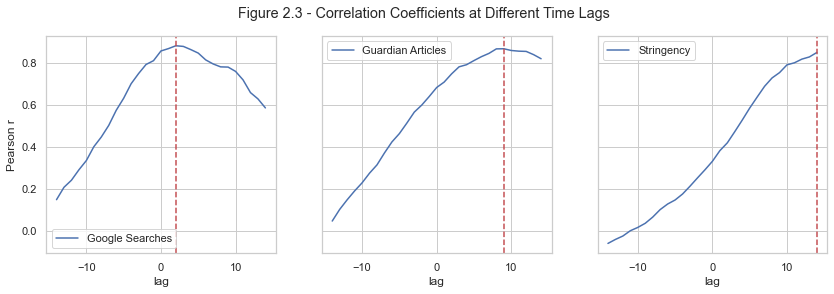

In [67]:
def ts_corr(x, y, start, stop):
    '''
    This function computes the correlation coefficients of two time series for a range of different lags and returns a pandas dataframe
    '''
    
    def corr(lag):
        return x.shift(lag).corr(y)
    
    corr_list = [(lag, corr(lag)) for lag in range(int(start),int(stop+1))]
    df = pd.DataFrame.from_records(corr_list, columns = ['lag', 'corr'])
    df = df.set_index('lag', drop=True)

    return df

predictors = ['coronavirus', 'webTitle', 'government_response_index']
corr_list = [ts_corr(x=df_total[predictor], y=df_total['Volume'], start=-14, stop=14) for predictor in predictors] # Creating a list of dataframes for all variables
df_corrs = pd.concat(corr_list, axis=1, names=predictors) # Concatenating the list of dataframes

df_corrs.columns = ['corr_'+ name for name in predictors] # Renaming columns

# Plotting
f, axes = plt.subplots(1,3, figsize=(14, 4), sharex=True, sharey=True)
sns.lineplot(x=df_corrs.index, y='corr_coronavirus', data=df_corrs, label='Google Searches', ax=axes[0])
sns.lineplot(x=df_corrs.index, y='corr_webTitle', data=df_corrs, label='Guardian Articles', ax=axes[1])
sns.lineplot(x=df_corrs.index, y='corr_government_response_index', label='Stringency', data=df_corrs, ax=axes[2])
axes[0].axvline(df_corrs['corr_coronavirus'].idxmax(),color='r',linestyle='--')
axes[1].axvline(df_corrs['corr_webTitle'].idxmax(),color='r',linestyle='--')
axes[2].axvline(df_corrs['corr_government_response_index'].idxmax(),color='r',linestyle='--')
axes[0].set(ylabel='Pearson r')
f.suptitle('Figure 2.3 - Correlation Coefficients at Different Time Lags')
plt.show()

## Part 2 - Discussion of Results

Firstly, we plot the time series of our response variable, FTSE 100 stock volume. Figure 2.1 shows both daily volume as well as a 5-day rolling average for ease of interpretation. We can see that volume started rising from the second half of February and peaked around the middle of March, after which it started following a downward trend. 

Figure 2.2 shows the time series plots of our three predictor variables. Firstly, like stock market volume, we can see that global Google searches for the term 'coronavirus' started rising from the middle of February and were highest during the middle of March, after which searches started decreasing. News articles by the Guardian, in contrast, peaked around one week later than Google searches, but remained high also for the period following this peak. Finally, the government response index shows a sligth increase around the end of January, after which it remains stable until the middle of March, when it increases towards a peak at which it remains until the end of April. 

In figure 2.3 we can see the pearson correlation coefficients ($r$) for each of our predictor variable time series with the volume time series at different time lags ranging between -14 days and +14 days. A vertical red line inidicates the time lag which results in the highest value of $r$. Firstly, what stands out from the plot straight away is the fact that the lags for which the correlation coefficient is highest is positive for all three predictors. This implies that the financial market is indeed forward looking and that expectations of future outcomes such as the government's response to the virus are taken into account by the market. 

Between the three different predictor variables, however, we do see stark differences in figure 2.3. The correlation coefficient for Google searches is maximized when it is pulled forward by only two additional days, while for news articles this point lies at 9 days and for government response it lies at our maximum value of 14 days (the true global optimum would most likely be even higher than 14). Furthermore, at a lag of 0 days, the correlation coefficient for Google searches is only marginally lower than at the global optimum (0.86 compared to 0.88). Thus, the number of Google searches for the term 'coronavirus' on a given day was nevertheless highly correlated with traded volume of the FTSE 100 stocks between January and May of 2020. 

## Limitations 

### Section 1

In my exploration of the association between hospital capacity and stringency of COVID-related measures, the choice of independent variable, the number of hospital beds available, may not fully capture the broader concept of hospital capacity. For instance, hospital capacity could be constrained due to a lack of trained staff or a shortage of personal protective equipment. 

Another limitation stems from the fact that I have only relied on bivariate analysis and have not controlled for all potential confounding variables. A potential next step could be address this research question with a multivariate analysis, which would improve the quality of our estimation of the effect of hospital capacity. 

Thirdly, due to the fact that the available data on hospital capacity is outdated for a significant number of countries, I removed these countries from the analysis altogether. This could have introduced bias into the analysis, for instance if the reasons for this unavailability correlate with government response. 

Furthermore, by looking at averages per country since their tenth case of COVID, we are obscuring the differences between the course of the pandemic between countries. If the virus spread very slowly during the beginning of the pandemic but afterwards case numbers increased dramatically, the average over this period may not be an accurate reflection of the course of the pandemic. 

Finally, the resulsts of this analysis hint at a negative relationship between hospital capacity and stringency, which implies that additional government spending on healthcare capacity could prevent governments from having to take very stringent measures such as closing schools that have negative social and economic consequences. Ultimately, when reflecting on the lessons learned from this pandemic, governments should consider 

### Section 2

My analysis of different predictors of stock market variation also has several limitations. Firstly, when looking at search trends and news articles, I have not differentiated between positive and negative content. For instance, while a news article about rising COVID case numbers may worry investors, news about a coronavirus vaccine may make them hopeful. Similarly, since I have only looked at one Google search term ('cornavirus'), I am forgoing potentially important nuances in search behavior that could explain more of the outcomes. Future research could address these issues, for instance, by incorporating sentiment analysis. 

Secondly, by looking at Pearson's correlation coefficient, I am assuming that the underlying correlation is linear. However, This assumption may be too strong given that we could reasonbly argue that the people making stockmarket decisions monitor new developments closely and acts on new information more quickly than the average person. Therefore, the influence of initial rises in the number of news articles published or the popularity of a search term may have a larger marignal effect than the same proportional increase when attention was already high. 

Thirdly, the unit of time that we have looked at in this analysis has been days, but it could be that the effect that we are interested in does not occure over a matter of days but rather hours or minutes. 

Fourthly, while I have chosen to measure the predictor variables - search trends, news, and government response - on a global scale, the dependent variable considers only companies whose shares are listed on the London Stock Exchange. While financial markets are widely considered to be globally linked, the fact the I have looked at just this small selection of large companies may have introduced bias into the analysis. 

Finally, this analysis has merely looked at the correlation of pairs of variables over time. If we wanted to attempt to infer causality between the two variables we would have to use more advanced statistical methods and integrate control vairables into the analysis. Given the nature of investment decisions, however, this intricate relationship may be very difficult to fully unpack.  

# References

Baig, A. S., Butt, H. A., Haroon, O., & Rizvi, S. A. R. (2020). Deaths, panic, lockdowns and US equity markets: The case of COVID-19 pandemic. Finance Research Letters, 101701. https://doi.org/10.1016/j.frl.2020.101701

Baker, S. R., Bloom, N., Davis, S. J., Kost, K., Sammon, M., & Viratyosin, T. (2020). The unprecedented stock market reaction to COVID-19. The Review of Asset Pricing Studies, 10(4), 742–758.

Barrero, J. M., & Bloom, N. (2020). Economic uncertainty and the recovery. Unpublished Manuscript.

Bauer, J., Brüggmann, D., Klingelhöfer, D., Maier, W., Schwettmann, L., Weiss, D. J., & Groneberg, D. A. (2020). Access to intensive care in 14 European countries: a spatial analysis of intensive care need and capacity in the light of COVID-19. Intensive Care Medicine, 46(11), 2026–2034. https://doi.org/10.1007/s00134-020-06229-6

Bonaccorsi, G., Pierri, F., Cinelli, M., Flori, A., Galeazzi, A., Porcelli, F., Schmidt, A. L., Valensise, C. M., Scala, A., & Quattrociocchi, W. (2020). Economic and social consequences of human mobility restrictions under COVID-19. Proceedings of the National Academy of Sciences, 117(27), 15530–15535.

Strekalova, Y. A. (2017). Health risk information engagement and amplification on social media: News about an emerging pandemic on Facebook. Health Education & Behavior, 44(2), 332–339.

Davies, N. G., Kucharski, A. J., Eggo, R. M., Gimma, A., Edmunds, W. J., Jombart, T., O’Reilly, K., Endo, A., Hellewell, J., Nightingale, E. S., Quilty, B. J., Jarvis, C. I., Russell, T. W., Klepac, P., Bosse, N. I., Funk, S., Abbott, S., Medley, G. F., Gibbs, H., … Liu, Y. (2020). Effects of non-pharmaceutical interventions on COVID-19 cases, deaths, and demand for hospital services in the UK: a modelling study. The Lancet Public Health, 5(7), e375–e385. https://doi.org/10.1016/S2468-2667(20)30133-X

Elgin, C., Basbug, G., & Yalaman, A. (2020). Economic policy responses to a pandemic: Developing the COVID-19 economic stimulus index. Covid Economics, 1(3), 40–53.

Griffin, D., & Tversky, A. (1992). The weighing of evidence and the determinants of confidence. Cognitive Psychology, 24(3), 411–435.

Hale, T., Petherick, A., Phillips, T., & Webster, S. (2020). Variation in government responses to COVID-19. Blavatnik School of Government Working Paper, 31.

Haroon, O., & Rizvi, S. A. R. (2020). COVID-19: Media coverage and financial markets behavior - A sectoral inquiry. Journal of Behavioral and Experimental Finance, 100343.

Lange, S., & Vollmer, S. (2017). The effect of economic development on population health: a review of the empirical evidence. British Medical Bulletin, 121(1), 47–60. https://doi.org/10.1093/bmb/ldw052

Lindström, M. (2020). The COVID-19 pandemic and the Swedish strategy: Epidemiology and postmodernism. SSM - Population Health, 11, 100643. https://doi.org/https://doi.org/10.1016/j.ssmph.2020.100643

Lyócsa, Š., Baumöhl, E., Výrost, T., & Molnár, P. (2020). Fear of the coronavirus and the stock markets. Finance Research Letters, 36, 101735.

Mahdi, A., Blaszczyk, P., Dlotko, P., Salvi, D., Chan, T.-S. T., Harvey, J., Gurnari, D., Wu, Y., Farhat, A., Hellmer, N., Zarebski, A. E., Hogan, B., & Tarassenko, L. (2020). OxCOVID19 Database: a multimodal data repository for better understanding the global impact of COVID-19. MedRxiv, 2020.08.18.20177147. https://doi.org/10.1101/2020.08.18.20177147

Malkiel, B. G. (1989). Efficient market hypothesis. In Finance (pp. 127–134). Springer.

Moat, H. S., Curme, C., Avakian, A., Kenett, D. Y., Stanley, H. E., & Preis, T. (2013). Quantifying Wikipedia usage patterns before stock market moves. Scientific Reports, 3(1), 1–5.

Preis, T., Reith, D., & Stanley, H. E. (2010). Complex dynamics of our economic life on different scales: insights from search engine query data. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 368(1933), 5707–5719.

Preis, T., Moat, H. S., & Stanley, H. E. (2013). Quantifying trading behavior in financial markets using Google Trends. Scientific Reports, 3, 1684.

Sebhatu, A., Wennberg, K., Arora-Jonsson, S., & Lindberg, S. I. (2020). Explaining the homogeneous diffusion of COVID-19 nonpharmaceutical interventions across heterogeneous countries. Proceedings of the National Academy of Sciences of the United States of America, 117(35), 21201–21208. https://doi.org/10.1073/pnas.2010625117

Si, J., Mukherjee, A., Liu, B., Li, Q., Li, H., & Deng, X. (2013). Exploiting topic based twitter sentiment for stock prediction. Proceedings of the 51st Annual Meeting of the Association for Computational Linguistics (Volume 2: Short Papers), 24–29.

Stier, A., Berman, M., & Bettencourt, L. (2020). COVID-19 attack rate increases with city size. Mansueto Institute for Urban Innovation Research Paper Forthcoming.

Strekalova, Y. A. (2017). Health risk information engagement and amplification on social media: News about an emerging pandemic on Facebook. Health Education & Behavior, 44(2), 332–339.

Sussman, N. (2020). Time for Bed(s): Hospital Capacity and Mortality from COVID-19. Covid Economics, 116.
